In [2]:
import nest_asyncio

nest_asyncio.apply()

import os


# llama parser key
## create API key at https://cloud.llamaindex.ai/api-key
os.environ["LLAMA_CLOUD_API_KEY"] = "YOUR API KEY"


In [3]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


def init_epam_azure_openai():
    OPENAI_DEPLOYMENT_NAME = "gpt-4o-2024-05-13"  # "gpt-35-turbo"
    OPENAI_API_KEY = "59367220deac40359ca02bd1a952e87c"
    OPENAI_API_VERSION = "2023-07-01-preview"
    OPENAI_API_ENDPOINT = "https://ai-proxy.lab.epam.com"

    from langchain_openai.chat_models.azure import AzureChatOpenAI

    llm = AzureChatOpenAI(
        openai_api_key=OPENAI_API_KEY,
        openai_api_version=OPENAI_API_VERSION,
        azure_endpoint=OPENAI_API_ENDPOINT,
        azure_deployment=OPENAI_DEPLOYMENT_NAME,
        verbose=True,
    )

    embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

    return llm, embed_model


/Users/pratikvyas/Library/CloudStorage/OneDrive-EPAM/Pratik/Projects/GenAI/forrm10K_llama_index/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from llama_index.core import Settings

llm, embed_model = init_epam_azure_openai()

Settings.llm = llm
Settings.embed_model = embed_model

In [5]:
from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
)

In [6]:
file_path = "/Users/pratikvyas/Downloads/test_doc/mcd_0000063908_2021.htm"


documents = parser.get_json_result(file_path)[0]["pages"]

Started parsing the file under job_id c8a691f5-c2d5-48ae-a705-dc08b0c94113


In [7]:
from llama_index.core.schema import TextNode, Node
import json


def get_text_nodes(documents):
    """Split docs into nodes, by separator."""
    nodes_md = []
    nodes_txt = []
    for doc in documents:
        md_texts = "".join(doc["md"])
        if md_texts.strip():
            node = TextNode(text=md_texts, metadata={"Page Number ": doc["page"]})
            nodes_md.append(node)

        txt_texts = "".join(doc["text"])
        if txt_texts.strip():
            node = TextNode(text=txt_texts, metadata={"PageNumber ": doc["page"]})
            nodes_txt.append(node)

    return nodes_md, nodes_txt

In [8]:
from unstructured.partition.html.partition import partition_html
from unstructured.documents.elements import Table, Text


def get_table_nodes(html_file_path):
    html_elements = partition_html(filename=html_file_path)

    tables_nodes = []

    for element in html_elements:
        if isinstance(element, Table):
            node_text = element.metadata.text_as_html
            table_node = Node(text=node_text)
            tables_nodes.append(table_node)

    return tables_nodes


In [9]:
from llama_index.core.node_parser import MarkdownElementNodeParser, SentenceSplitter
from llama_index.core.node_parser import HierarchicalNodeParser

splitter = HierarchicalNodeParser.from_defaults(chunk_sizes=[2048, 512, 128])

nodes_md, nodes_text = get_text_nodes(documents=documents)


nodes_table = get_table_nodes(file_path)
nodes_text_ = splitter.get_nodes_from_documents(nodes_text)


In [10]:
from llama_index.core import VectorStoreIndex, SummaryIndex

vector_index_text = VectorStoreIndex(
    nodes=nodes_text_, embed_model=Settings.embed_model
)
vector_index_md = VectorStoreIndex(nodes=nodes_md, embed_model=Settings.embed_model)
vector_index_tables = VectorStoreIndex(
    nodes=nodes_table, embed_model=Settings.embed_model
)


In [11]:
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.postprocessor.colbert_rerank import ColbertRerank

response_synthesizer = get_response_synthesizer(response_mode=ResponseMode.COMPACT)

vector_retriever_text = vector_index_text.as_retriever(similarity_top_k=8)

retriever_query_engine_text = RetrieverQueryEngine(
    retriever=vector_retriever_text,
    #    response_synthesizer=response_synthesizer,
    node_postprocessors=[
        SimilarityPostprocessor(
            similarity_cutoff=0.60,
            filter_similar=True,
            filter_deuplicate=True,
            filter_empty=True,
        )
    ],
)

vector_retriever_md = vector_index_md.as_retriever(similarity_top_k=8)
retriever_query_engine_md = RetrieverQueryEngine(
    retriever=vector_retriever_md,
    #    response_synthesizer=response_synthesizer,
    node_postprocessors=[
        SimilarityPostprocessor(
            similarity_cutoff=0.60,
            filter_similar=True,
            filter_deuplicate=True,
            filter_empty=True,
        )
    ],
)


simple_query_engine_text = vector_index_text.as_query_engine(
    similarity_top_k=8, node_postprocessors=[ColbertRerank(top_n=3)]
)

simple_query_engine_md = vector_index_md.as_query_engine(
    similarity_top_k=8, node_postprocessors=[ColbertRerank(top_n=3)]
)

simple_query_engine_html_tables = vector_index_tables.as_query_engine(
    similarity_top_k=8, node_postprocessors=[ColbertRerank(top_n=3)]
)


In [12]:
# from llama_index.agent.openai import OpenAIAgent
from llama_index.core.tools import QueryEngineTool, ToolMetadata, FunctionTool
from llama_index.core.agent import ReActAgent, Task


tool_Form10K_txt = QueryEngineTool(
    query_engine=simple_query_engine_text,
    metadata=ToolMetadata(
        name="tool_Form10K_txt",
        description="use this tool to search context and answer user query.",
    ),
)


tool_Form10K_md = QueryEngineTool(
    query_engine=simple_query_engine_md,
    metadata=ToolMetadata(
        name="tool_Form10K_md",
        description="use this tool to search context and answer user query.",
    ),
)


tool_Form10K_table = QueryEngineTool(
    query_engine=simple_query_engine_html_tables,
    metadata=ToolMetadata(
        name="tool_Form10K_table",
        description="Use this tool for search and analysis.\
                  * It contain html tables with number. \
                  * Parse HTML table for accurate result. \
                  * Make sure you are exracting from relevant row and column.",
    ),
)

tools = [tool_Form10K_txt, tool_Form10K_table]


In [13]:
import matplotlib.pyplot as plt
from llama_index.core.tools import FunctionTool


def display_bar_chart(data, labels):
    """
    Display a bar chart using the given data and labels.

    Args:
        data (list): The data values for each bar.
        labels (list): The labels for each bar.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the bar chart
    ax.bar(labels, data)

    # Add labels and title
    ax.set_xlabel("Categories")
    ax.set_ylabel("Values")
    ax.set_title("Bar Chart")

    # Display the chart
    plt.show()


# display_bar_chart([10, 20], ["l1", "l2"])


barchart_tool = FunctionTool.from_defaults(
    fn=display_bar_chart,
    name="tool_barchart",
    description="Use this tool to display bar chart.",
)


tool_barchart = FunctionTool(
    fn=barchart_tool,
    metadata=ToolMetadata(
        name="tool_barchart",
        description="""Use this tool to display bar chart. 
                        Args:
                         - data (list): The data values for each bar.
                         - labels (list): The labels for each bar.
        """,
    ),
)

tools = [tool_Form10K_txt, tool_Form10K_table, tool_Form10K_md, tool_barchart]


In [14]:
# financial dictionary. This will be used to generate sub-question and guided prompt.

financial_dictionary_PERatio = {
    "name": "financial_dictionary_PERatio",
    "description": "Use this dictionary term to calculates PE ratio as per below instructions.\
            1) perform search for latest market_price_of_share for a given period. \
            2) perform search for latest earnings_per_share for a given period.\
            3) calculate PE ratio by dividing market_price_of_share with earnings_per_share\
            4) finally use tool_barchart to display bar chart. pass arguments as below \
                    - data= list of PE ratio \
                    - labels= list of years",
}


In [60]:
# generate sub-question based on user query


def generate_subquestions(llm, query, tools, finacial_dictionary_json=None):
    tools_dict = {}
    for tool in tools:
        tools_dict[tool.metadata.name] = tool.metadata.description

    tools_str = json.dumps(tools_dict, indent=4)

    finacial_dictionary = {}

    if finacial_dictionary_json is not None:
        for dict in finacial_dictionary_json:
            name = dict["name"]
            desc = dict["description"]
            finacial_dictionary[name] = desc
        finacial_dictionary_str = json.dumps(finacial_dictionary, indent=4)
    else:
        finacial_dictionary_str = ""

    prompt = f"""You are a world class state of the art agent.
    You have access to multiple tools, each representing a different data source or API.
    Each of the tools has a name and a description, formatted as a JSON dictionary.
    The keys of the dictionary are the names of the tools and the values are the \
    descriptions.
    Your purpose is to help answer a complex user question by generating a list of sub \
    questions that can be answered by the tools.
    
    Take the help of finacial_dictionary while generating a list of sub questions. Finacial_dictionary has a name and a description, formatted as a JSON dictionary. The keys of the dictionary are finacial jargon and the values are the descriptions about how to calculate it.

    These are the guidelines you consider when completing your task:
    * Be as specific as possible.
    * The sub questions should be relevant to the user question.
    * The sub questions should be answerable by the tools provided.
    * You can generate multiple sub questions for each tool.
    * Use all relevant tools to generate sub questions.
    * Take help from finacial_dictionary to generate sub questions. 
    * Tools must be specified by their name, not their description
    * You don't need to use a tool if you don't think it's relevant
    * You don't need to use a finacial_dictionary if you don't think it's relevant
     


    Output the list of sub questions in json with key as tool name and value is list of subquestions.

    ## Tools
    {tools_str}

    ## finacial_dictionary
    {finacial_dictionary_str}


    ## User Question
    {query} """

    lst = llm.invoke(prompt)

    content = str(lst.content)
    # print(content)

    # print("---")
    start_index = content.index("```json") + len("```json")
    end_index = len(content)  # content.index('```')

    json_substring = content[start_index:end_index]

    # return json_substring.replace("```", "")
    sub_questions = content.replace("```", "").replace("json", "").replace("```", "")
    return (
        "\n- Use below tools and sub-questions to answer user query. Use all avilable tools if you don't find answer in a specific tool.\n"
        + sub_questions
    )


In [74]:
# elaborate user query
def elaborate_query(query_str):
    prompt_temp = f"""Please elaborate user query mention below pointwise in 5 lines.\n
                  Make sure it is to the point and clear.
                  Try to include as many key details as possible.\n
                    \n
                    \n
                    {query_str}\n
                    \n
                    \n
                    elaborate:\n"""

    lst = llm.invoke(prompt_temp)
    sub_questions = lst.content

    query_str = query_str + "\n- Details about query:\n" + str(sub_questions)

    return query_str

In [79]:
query_str = "What is PE ratio for 2021,2020,2019?"

# optional : elaborate user query
query_str = elaborate_query(query_str)

sub_questions = generate_subquestions(
    llm=llm,
    query=query_str,
    tools=tools,
    finacial_dictionary_json=[
        financial_dictionary_PERatio,
    ],
)

## add sub quesion to query
query_str = "- User Query : " + query_str + "\n" + str(sub_questions)
print(query_str)

- User Query : What is PE ratio for 2021,2020,2019?
- Details about query:
1. **Definition**: The Price-to-Earnings (PE) ratio is a financial metric used to evaluate the valuation of a company's stock by comparing its current share price to its earnings per share (EPS).

2. **PE Ratio for 2021**: The PE ratio for 2021 is calculated by dividing the company's stock price at the end of 2021 by its EPS for the year 2021.

3. **PE Ratio for 2020**: Similarly, the PE ratio for 2020 is obtained by dividing the stock price at the end of 2020 by the EPS for the year 2020.

4. **PE Ratio for 2019**: The PE ratio for 2019 is determined by dividing the stock price at the end of 2019 by the EPS for the year 2019.

5. **Comparison and Analysis**: Comparing these PE ratios over the three years can provide insights into the company's valuation trends, investor sentiment, and potential growth or risk factors.

- Use below tools and sub-questions to answer user query. Use all avilable tools if you don't

In [80]:
agent = ReActAgent.from_tools(
    tools=tools,
    verbose=True,
    max_iterations=50,
    llm=Settings.llm,
    system_prompt=""" \
     You are an agent act as a financial assistance to answer queries with step by step in markdown about Form 10K. \
     """,
    #  tool_retriever=obj_index.as_retriever(similarity_top_k=3),
)


> Running step 0b941a92-7d06-4cbf-be79-82fc0fe9fac4. Step input: - User Query : What is PE ratio for 2021,2020,2019?
- Details about query:
1. **Definition**: The Price-to-Earnings (PE) ratio is a financial metric used to evaluate the valuation of a company's stock by comparing its current share price to its earnings per share (EPS).

2. **PE Ratio for 2021**: The PE ratio for 2021 is calculated by dividing the company's stock price at the end of 2021 by its EPS for the year 2021.

3. **PE Ratio for 2020**: Similarly, the PE ratio for 2020 is obtained by dividing the stock price at the end of 2020 by the EPS for the year 2020.

4. **PE Ratio for 2019**: The PE ratio for 2019 is determined by dividing the stock price at the end of 2019 by the EPS for the year 2019.

5. **Comparison and Analysis**: Comparing these PE ratios over the three years can provide insights into the company's valuation trends, investor sentiment, and potential growth or risk factors.

- Use below tools and sub-qu

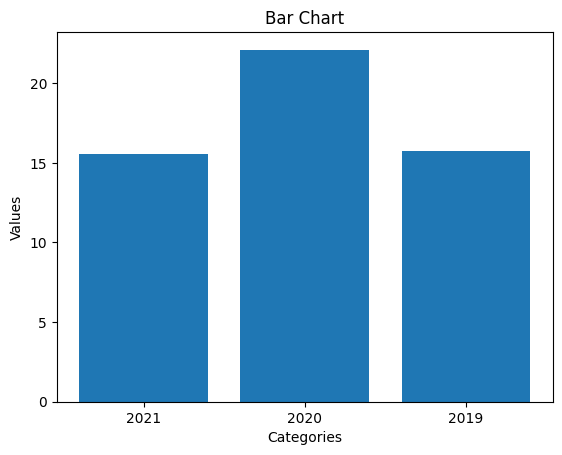

Observation: None
> Running step 746f2b2f-6a19-461e-88d1-aef7ee584f2a. Step input: None
Thought: I can now summarize the PE ratios for the years 2021, 2020, and 2019 based on the calculations I have done.
Answer: The PE ratios for the company over the three years are as follows:
- **2021**: 15.55
- **2020**: 22.10
- **2019**: 15.76

These values indicate how the market valuation of the company's stock has varied in relation to its earnings over these years.
=====LLM Reply======
The PE ratios for the company over the three years are as follows:
- **2021**: 15.55
- **2020**: 22.10
- **2019**: 15.76

These values indicate how the market valuation of the company's stock has varied in relation to its earnings over these years.


In [81]:
## LLM response. Json part in query are sub-questions generated from above method
res = agent.query(str(query_str))

print("=====LLM Reply======")
print(res)
print("=============")


In [82]:
# source nodes from where response is generated

for node_with_score in res.source_nodes:
    print("\n**************")

    # Step 1: Access the TextNode
    text_node = node_with_score.node
    # Print the metadata
    print("-", text_node.metadata)
    print("\n- Text:\n", text_node.text)


**************
- {'PageNumber ': 28}

- Text:
 In 2021, approximately 3.4 million shares were
repurchased for $845.5 million, bringing total purchases under the program to approximately 7.7 million shares or $1.7 billion.
      The Company has paid dividends on its common stock for 46 consecutive years and has increased the dividend amount every year. The 2021 full
year dividend of $5.25 per share reflects the quarterly dividend paid for each of the first three quarters of $1.29 per share, with an increase to $1.38
per share paid in the fourth quarter.

**************
- {'PageNumber ': 73}

- Text:
 A summary of the status of the Company’s stock option grants as of December 31, 2021, 2020 and 2019, and changes during the years then
ended, is presented in the following table:

                                                                                                                     2021                               2020                                 2019
                  